In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#%run ./data.ipynb

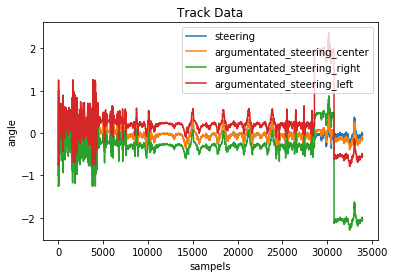

(33924, 11)


,index,center,left,right,steering,throttle,brake,speed,argumentated_steering_center,argumentated_steering_right,argumentated_steering_left
0,0,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
1,1,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
2,2,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
3,3,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
4,4,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
5,5,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
6,6,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
7,7,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
8,8,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000
9,9,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# read csv
def get_csv(path,offset_argumented_steering_left = 0.25 ,offset_argumented_steering_center = 0,offset_argumented_steering_right = -0.25):
    # load CSV & drop zeros
    df = pd.read_csv(path+'driving_log.csv')
    df = df.drop(df[df['steering'] == 0.].index)
    df = df.drop(df[df['speed'] < 1.].index)
    df['center'] = path+df['center']
    df['right'] = path+df['right']
    df['left'] = path+df['left']
    df['argumentated_steering_center'] = df['steering'] + offset_argumented_steering_center
    df['argumentated_steering_right' ] = df['steering'] + offset_argumented_steering_right
    df['argumentated_steering_left'  ] = df['steering'] + offset_argumented_steering_left
    return df

tracks = [get_csv(path = './track_data/andy_track1_offroad/'),\
          get_csv(path = './track_data/andy_track1_offroad2/'),\
          get_csv(path = './track_data/data/'),\
          get_csv(path = './track_data/peters_drive/'),\
          get_csv(path = './track_data/andy_track1_backward/'),\
          get_csv(path = './track_data/andy_track1_forward/'),\
          get_csv(path = './track_data/andy_track1_exact_drive/'),\
          get_csv(path = './track_data/andy_track1_exact_drive2/'),\
          get_csv(path = './track_data/andy_track1_exact_drive3/'),\
          get_csv('./track_data/andy_track1_left/',2,.1,.5),\
          get_csv('./track_data/andy_track1_right/',-.5,-.1,-2),\
         ]
df = pd.concat(tracks).reset_index()

def plot_steering(df):
    ### plot 
    cols = ['steering','argumentated_steering_center','argumentated_steering_right','argumentated_steering_left']
    plt.plot(df[cols])
    plt.title('Track Data')
    plt.ylabel('angle')
    plt.xlabel('sampels')
    plt.legend(cols, loc='upper right')
    #plt.yscale('log')
    plt.show()
    
plot_steering(df)
print(df.shape)
df

In [4]:
def add_steering_classes_asym(df,n_classes):
    range_classes = sorted((df['steering']))[::int(len(df)/n_classes)][:]
    range_classes[0] = -np.inf
    range_classes[-1] = np.inf
    ##range_classes = (np.asarray(list(range(n_classes)))/n_classes*2 -1) 
    for j in (df.index):
        for i, range_class in enumerate(range_classes):
            if((df['steering'][j]) >= range_class):
                df.ix[j,'classes'] = i
                
    df['steering'].astype(int)
    return df , range_classes

def add_steering_classes(df,n_classes = 10):
    range_classes = sorted(np.abs(df['steering']))[::int(len(df)/n_classes)][1:]
    range_classes = np.append(np.asarray(list(range(n_classes)))[:] * range_classes[-2]/n_classes,1e6)
    for j in (df.index):
        for i, range_class in enumerate(range_classes):
            if(np.abs(df['steering'][j]) >= range_class):
                df.ix[j,'classes'] = i
                
    df['steering'].astype(int)
    return df , range_classes


def df_info(df,range_classes):
    plt.plot(sorted(np.abs(df['steering'])));
    plt.show()
    plt.plot(df['classes']);
    plt.show()
    print(range_classes)
    plt.plot(sorted(df['classes']));
    plt.show()

In [5]:
%time df, range_classes = add_steering_classes_asym(df,n_classes = 8)
#%time df, range_classes = add_steering_classes(df,n_classes = 6)
df

Wall time: 9min 47s


,index,center,left,right,steering,throttle,brake,speed,argumentated_steering_center,argumentated_steering_right,argumentated_steering_left,classes
0,0,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
1,1,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
2,2,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
3,3,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
4,4,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
5,5,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
6,6,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
7,7,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
8,8,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0
9,9,./track_data/andy_track1_offroad/IMG/center_20...,./track_data/andy_track1_offroad/IMG/left_2017...,./track_data/andy_track1_offroad/IMG/right_201...,-1.000000,0.000000,0.0,10.000000,-1.000000,-1.250000,-0.750000,0.0


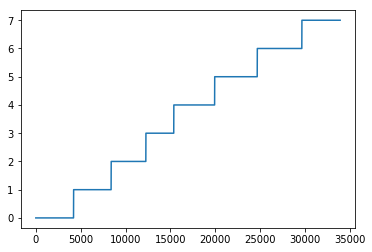

'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

[-inf,
 -0.14999999999999999,
 -0.084905659999999994,
 -0.056603769999999998,
 -0.037735850000000001,
 -0.01886792,
 -0.0094339619999999989,
 0.075471700000000003,
 inf]

In [6]:
plt.plot(sorted(df['classes'].values));
plt.show()
sorted(df['classes'].values).__repr__()
range_classes

In [7]:
# split data
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=1/21, random_state=42)

In [8]:
# argumentation and batching parameters:

image_shape = (160,320,3) #cv2.imread( df['center'][df['center'].index[0]]).shape
batch_size_single = 6
steering_argumentation_target_distance = 33

# generate argumentated batch
from sklearn.utils import shuffle
import traceback
import sys

def fill_batch(df,idxes):
    #try:
    batch_y            = np.empty(list([batch_size_single*6]))
    batch_x            = np.empty(list([batch_size_single*6]) + list(image_shape))
    idx_b = 0
    cnt = 0
    for idx in idxes:
        batch_y[0+idx_b]      = (df['argumentated_steering_center'].iloc[idx])
        batch_y[1+idx_b]      = (df['argumentated_steering_left'  ].iloc[idx])
        batch_y[2+idx_b]      = (df['argumentated_steering_right' ].iloc[idx])
        batch_y[3+idx_b]      = -batch_y[0+idx_b]
        batch_y[4+idx_b]      = -batch_y[1+idx_b]
        batch_y[5+idx_b]      = -batch_y[2+idx_b]
        batch_x[0+idx_b]      = cv2.imread(df['center'].iloc[idx].replace(" ", "").replace("\\", "/")) 
        batch_x[1+idx_b]      = cv2.imread(df['left'  ].iloc[idx].replace(" ", "").replace("\\", "/"))
        batch_x[2+idx_b]      = cv2.imread(df['right' ].iloc[idx].replace(" ", "").replace("\\", "/"))  
        batch_x[3+idx_b]      = batch_x[0+idx_b][:,-1::-1]
        batch_x[4+idx_b]      = batch_x[1+idx_b][:,-1::-1]
        batch_x[5+idx_b]      = batch_x[2+idx_b][:,-1::-1]
        idx_b += 6
    assert(not(np.isnan((np.sum(batch_x))))), 'is nan'
    assert(not(np.isnan((np.sum(batch_y))))), 'is nan'
    cnt +=1
    #print('len(batch_x)',len(batch_x))
    return shuffle(batch_x,batch_y)
    #yield shuffle(batch_x,batch_y) 
    #except:
    #    print("\r\n\r\nUnexpected error: {} \r\n\r\n".format(sys.exc_info()[0]))
    #    raise

def get_batch(df,batch_size_single): 
    n_split = int(len(df)//batch_size_single)-1
    batch_idx = (df[:batch_size_single*n_split].index.values)   
    batch_idx = shuffle(batch_idx)
    batch_idx = batch_idx.reshape(n_split,batch_size_single,)
    while 1:
        #print('\r\nget_batch: start ',flush=True)
        cnt = 0
        for idxes in batch_idx:
            try:
                yield (fill_batch(df,idxes))
            except:
                print("\r\n\r\nUnexpected error: {} \r\n\r\n".format(sys.exc_info()[0]))
                raise

def get_stratified_batch(df,batch_size_single):
    
    from sklearn.model_selection import StratifiedShuffleSplit
    random_state=42
    
    while 1:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
        train_index, test_index = next(sss.split(df.index.values.copy(), df['classes']))
        
        n_split = int(len(train_index)//batch_size_single)-1
        batch_idx = (train_index[:batch_size_single*n_split])   
        batch_idx = shuffle(batch_idx)
        batch_idx = batch_idx.reshape(n_split,batch_size_single,)
    
        cnt = 0
        for idxes in batch_idx:
            #try:
            batch_x,batch_y, = (fill_batch(df,idxes))
            yield batch_x,batch_y
            #except:
            #    print("\r\n\r\nUnexpected error: {} \r\n\r\n".format(sys.exc_info()[0]))
            #    raise

#train_generator = get_batch(df_train, batch_size_single=batch_size_single)
#validation_generator = get_batch(df_val, batch_size_single=batch_size_single)

train_generator = get_stratified_batch(df_train, batch_size_single=batch_size_single)
validation_generator = get_stratified_batch(df_val, batch_size_single=batch_size_single)


(36, 160, 320, 3)


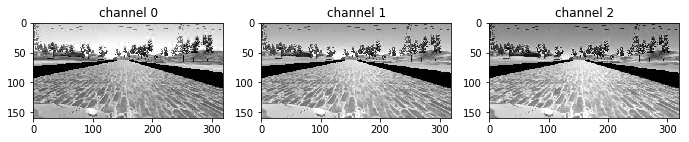

steering: -0.27830189, idx: 0


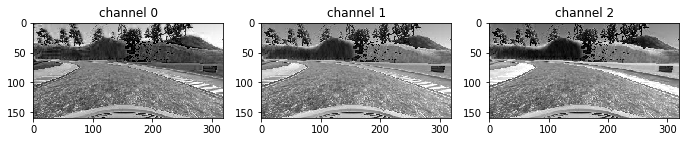

steering: -0.1415094, idx: 6


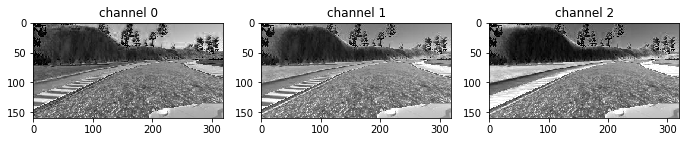

steering: 0.5424528, idx: 12


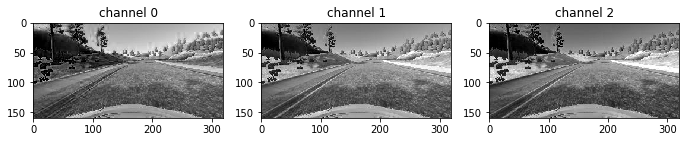

steering: 0.1754717, idx: 18


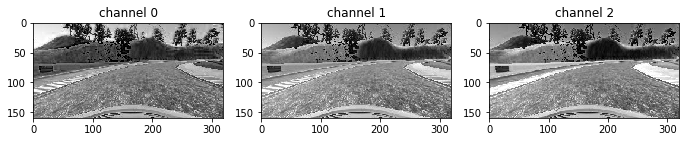

steering: 0.1415094, idx: 24


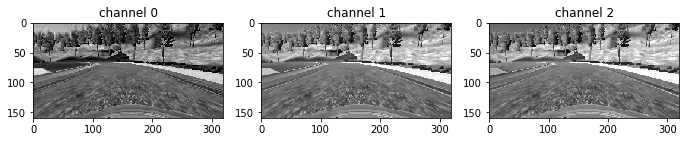

steering: -0.3009732, idx: 30
Wall time: 19.5 s


In [ ]:
import matplotlib

def plot_history_object(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.yscale('log')
    plt.show()

def visualise_dataset(image,label,steps):
    plt_num = 1
    print(image.shape)
    step_size = int(image.shape[0]/steps)
    for image_idx in range(0,image.shape[0],step_size):
        channels = image.shape[3]
        plt.figure(plt_num, figsize=(32,32))
        for channel in range(channels):
            plt.subplot(4,8, channel+1) # sets the number of feature maps to show on each row and column
            plt.title('channel ' + str(channel)) # displays the feature map number
            plt.imshow(image[image_idx,:,:,channel], interpolation="nearest",cmap="gray") # cmap="gist_earth_r"
        plt.show()
        print('steering: {1}, idx: {0}'.format(image_idx,label[image_idx],))

batch_x,batch_y = next(train_generator)
%time visualise_dataset(batch_x,batch_y,steps=6 )#* batch_size_single)


In [ ]:
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback, RemoteMonitor

import tensorflow as tf

# Hyperparameter Compile
loss= 'mse' # 'hinge'
optimizer= 'Nadam' #'Nadam' #'rmsprop'

# Hyperparameter Fit
rounds = 1
n_batches = len(df_train)//batch_size_single

nb_epoch= n_batches * rounds
batch_size = batch_size_single * 6
patience=5000

print('nb_epoch   \t: {:>5}'.format(nb_epoch))
print('batch_size \t: {:>5}'.format(batch_size))
print('patience   \t: {:>5}'.format(patience))

def model_a():
    model = Sequential()
    model.add(Cropping2D(cropping=((65,23), (0,0)), input_shape=image_shape)) #23
    #model.add(Lambda(lambda x: (x[:,:,:,0:1]+x[:,:,:,1:2]+x[:,:,:,2:3])/3)) ## drive on gray
    model.add(Lambda(lambda x: x/127.5 - 1.))
    output_shape = ((model.layers[-1].output_shape))
    #model.add(Reshape((output_shape[1]*2,int(output_shape[2]/2),output_shape[3],)))
    a = 4
    model.add(Convolution2D(2**(a+0), 9, 9, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+1), 7, 7, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+2), 5, 5, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(2**(a+3), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+4), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+5), 3, 3, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())  
    model.add(Flatten())
    model.add(Dropout(.66))
    model.add(Dense(4**4, activation = 'sigmoid'))
    model.add(Dense(3**3, activation = 'linear'))
    model.add(Dense(2**2, activation = 'linear'))
    model.add(Dense(1**1, activation = 'linear'))
    return model


try:
    #model = load_model('model.h5')
    model = model_a()
    print("model init done")
    model.load_weights("model.h5")
    print("load_weights done")
except:
    print("load_weights failed")
    model = model_a()
  
model.summary()

%time model.compile(loss=loss, optimizer=optimizer)

losses = []
def save_loss(epoch, logs):
    #print(epoch)
    try:
        #print(logs)
        losses.append(logs['loss'])
        #plt.plot(losses)
        #plt.title('loss history')
        #plt.ylabel('loss')
        #plt.xlabel('batch')
        #plt.yscale('log')
        #plt.show()
    except:
        pass

def callbacks():
    remote = RemoteMonitor()
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience,verbose=1,)
    model_checkpoit = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    save_loss_callback = LambdaCallback(on_batch_end=save_loss)
    #return [remote, early_stopping,model_checkpoit,save_loss_callback]
    return [model_checkpoit]

history_objects = []
while(1):
    history_object = model.fit_generator(generator         = train_generator, \
                        samples_per_epoch = batch_size*6, \
                        validation_data   = validation_generator, \
                        nb_val_samples    = 1, \
                        nb_epoch          = nb_epoch,\
                        callbacks         = callbacks() \
                                        )
    try:
        history_objects += history_object
    except:
        pass
    
    plot_history_object(history_object)

#import winsound
#winsound.Beep(130,10000)

Using TensorFlow backend.


nb_epoch   	:  5384
batch_size 	:    36
patience   	:  5000
model init done
load_weights done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 72, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 72, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 160, 16)   3904        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 18, 80, 32)    25120       convolution2d_1[0][0]          

216/216 [==============================] - 35s - loss: 0.1729 - val_loss: 0.1541
Epoch 45/5384
216/216 [==============================] - 35s - loss: 0.0738 - val_loss: 0.0585
Epoch 46/5384
216/216 [==============================] - 35s - loss: 0.2215 - val_loss: 0.1081
Epoch 47/5384
216/216 [==============================] - 37s - loss: 0.3245 - val_loss: 0.4963
Epoch 48/5384
216/216 [==============================] - 35s - loss: 0.2574 - val_loss: 0.1465
Epoch 49/5384
216/216 [==============================] - 35s - loss: 0.2095 - val_loss: 0.3334
Epoch 50/5384
216/216 [==============================] - 35s - loss: 0.2398 - val_loss: 0.1633
Epoch 51/5384
216/216 [==============================] - 35s - loss: 0.2088 - val_loss: 0.1799
Epoch 52/5384
216/216 [==============================] - 35s - loss: 0.2390 - val_loss: 0.0664
Epoch 53/5384
216/216 [==============================] - 35s - loss: 0.1732 - val_loss: 0.5812
Epoch 54/5384
216/216 [==============================] - 35s - l

216/216 [==============================] - 56s - loss: 0.1551 - val_loss: 0.0861
Epoch 131/5384
216/216 [==============================] - 54s - loss: 0.1998 - val_loss: 0.1481
Epoch 132/5384
216/216 [==============================] - 55s - loss: 0.1683 - val_loss: 0.0354
Epoch 133/5384
216/216 [==============================] - 60s - loss: 0.1277 - val_loss: 0.2883
Epoch 134/5384
216/216 [==============================] - 47s - loss: 0.1210 - val_loss: 0.2366
Epoch 135/5384
144/216 [===================>..........] - ETA: 15s - loss: 0.1564

In [ ]:
def plot_loss():
    plt.plot(losses)
    plt.title('loss history')
    plt.ylabel('loss')
    plt.xlabel('batch')
    plt.yscale('log')
    plt.show()

plot_loss()

In [ ]:
batch_x,batch_y = next(train_generator)
%time visualise_dataset(batch_x,batch_y,steps=60)

In [ ]:
import argparse
import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

#model = load_model('model.h5')
#print("load_model done")

sio = socketio.Server()
app = Flask(__name__)
prev_image_array = None


class SimplePIController:
    def __init__(self, Kp, Ki):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = 0.
        self.error = 0.
        self.integral = 0.

    def set_desired(self, desired):
        self.set_point = desired

    def update(self, measurement):
        # proportional error
        self.error = self.set_point - measurement
        # integral error
        self.integral += self.error
        return self.Kp * self.error + self.Ki * self.integral

controller = SimplePIController(0.1, 0.002)
set_speed = 5
controller.set_desired(set_speed)

@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        # The current throttle of the car
        throttle = data["throttle"]
        # The current speed of the car
        speed = data["speed"]
        # The current image from the center camera of the car
        imgString = data["image"]
        image = Image.open(BytesIO(base64.b64decode(imgString)))
        image_array = np.asarray(image)
        steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
        throttle = controller.update(float(speed))
        print(steering_angle, throttle)
        send_control(steering_angle, throttle)
    else:
        # NOTE: DON'T EDIT THIS.
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)

# wrap Flask application with engineio's middleware
app = socketio.Middleware(sio, app)

# deploy as an eventlet WSGI server
eventlet.wsgi.server(eventlet.listen(('', 4567)), app)



In [ ]:
#Todos:

'''
def get_StratifiedShuffleSplit(batches_idx,batch_size):
    n_bins  = 5
    batch_size = 5*7*7
    y_classes = df['steering'].copy()*n_bins//1
    batches_idx = df.index
    data_size = len(batches_idx)
    n_split = int(data_size//batch_size)-1
    print(n_split)
    batch_range = df.index
    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)
    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))
    
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    
    return batch_idx, val_idx

    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))
    batch_idx.shape
    
    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN
#from keras.layers.wrappers import TimeDistributed
#from keras.regularizers import l2, activity_l2


'''

In [ ]:
%whos

In [ ]:
df
